# Tutorial: The Cepheid Period-Luminosity Relation for Multiple Galaxies
## Fitting a bunch of lines... hierarchically!

The [`cepheids_one_galaxy`](cepheids_one_galaxy.ipynb) notebook looks at fitting a hierarchical model describing the period-luminosity relation and its intrinsic scatter to data from a single galaxy. Here we will think about the next logical level of hierarchical modeling, describing the similarity (or not) of such relations among galaxies. Note that it is not strictly necessary to have completed the above-linked tutorial to do this one, though it's the logical starting point if you intend to do both. You should however, work through the extremely brief [introduction to cepheid data](cepheids.ipynb) notebook before getting started here.

Specifically, you will
* expand the cepheid generative model to include prior distributions of the period-luminosity relation parameters ($a$, $b$ and $\sigma$) among galaxies;
* attempt a brute-force sampling of the now enormous number of model parameters;
* implement a more sensible approach where each galaxy's data is fit independently, and the results combined using importance weighting
* draw conclusions about whether each of the period-luminosity relation parameters is consistent with having a universal value among galaxies

## 1. Data

In [1]:
TutorialName = 'cepheid2'
exec(open('tbc.py').read()) # define TBC and TBC_above
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as st
import emcee
import incredible as cr
from pygtc import plotGTC

We'll begin by repeating the data preparation steps from the [Cepheids](cepheids.ipynb) notebook. For this first `TBC`, you can just copy/paste your solution from there.

In [3]:
cepheids = np.loadtxt('R11ceph.dat')
galaxies = np.loadtxt('R11redsh.dat')
ngc_numbers = [int(g) for g in galaxies[:,0]]
data = {int(x[0]):{'z':x[1]} for x in galaxies}
for g in ngc_numbers:
    j = np.where(cepheids[:,1] == g)[0]
    data[g]['id'] = np.array([int(i) for i in cepheids[j,0]])
    data[g]['Ngal'] = len(data[g]['id'])
    data[g]['m'] = cepheids[j,2]
    data[g]['merr'] = cepheids[j,3]
    data[g]['P'] = cepheids[j,4]
    data[g]['logO_H'] = cepheids[j,5]
    data[g]['bias'] = cepheids[j,6]
    data[g]['logP'] = np.log10(data[g]['P'])
c = 3.0e5 # km/s
H0 = 70.0 # km/s/Mpc
for g in ngc_numbers:
    data[g]['dL'] = c*data[g]['z']/H0
    data[g]['M'] = data[g]['m']-5*np.log(data[g]['dL'])+25

We should now have all the data loaded, named as it was before. As a reminder, these are the NGC numbers of the galaxies in the data set:

In [4]:
ngc_numbers

[1309, 3021, 3370, 3982, 4038, 4258, 4536, 4639, 5584]

## 2. A hierarchical model for all galaxies

Before charging forward, let's finish specifying the model. We previously said we would allow an intrinsic scatter about the overall period-luminosity relation - let's take that to be Gaussian such that the linear relation sets the mean of the scatter distribution, and there is an additional parameter for the width (in magnitudes), $\sigma_i$, for the $i$th galaxy. (Note that normal scatter in magnitudes, which are log-luminosity, could also be called log-normal scatter in luminosity; these are completely equivalent.)

Unlike the [single-galaxy tutorial](cepheids_one_galaxy.ipynb), here we will _not_ assume wide, uniform priors on the period-luminosity relation parameters, $a_i$, $b_i$ and $\sigma_i$, for each galaxy. Instead, let's add a level of hierarchy to the model by assuming that the values of $a$ for each galaxy come from a normal distribution with mean $\mu_a$ and standard deviation $\tau_a$, and similarly $b$ and $\sigma$ come from their own normal distributions. In the case of $\sigma$, the parent distribution must be truncated at 0, by definition.

For simplicity, we will not consider the possibility that, for example, all 3 come from a joint, multivariate normal distribution with possible correlations between them, although that could easily be justified. In practice, fitting for independent distributions for each parameter is a reasonable first step. This first attempt at answering the question of whether each period-luminosity parameter is universal thus boils down to constraining the hierarchical model, and determining whether each of the $\tau$ parameters is consistent with zero - if so, the corresponding parameter is consistent with having the same value for all galaxies in the sample. We will adopt wide, uniform priors on the new hyperparameters of the model ($\mu$s and $\tau$s), to make life easier.

All this represents a relatively simple modification to the your PGM and probabilistic expressions from the [single-galaxy tutorial](cepheids_one_galaxy.ipynb), and a slightly larger one compared with the [introduction](cepheids.ipynb) notebook. For completeness, the full set of model parameters is now:

* The observed apparent magnitude of the $j^{th}$ cepheid in the $i^{th}$ galaxy, $m^{\rm obs}_{ij}$
* The "true" apparent magnitude of the $j^{th}$ cepheid in the $i^{th}$ galaxy, $m_{ij}$
* The known observational uncertainty on the apparent magnitude of the $j^{th}$ cepheid in the $i^{th}$ galaxy, $\varepsilon_{ij}$
* The true absolute magnitude of the $j^{th}$ cepheid in the $i^{th}$ galaxy, $M_{ij}$
* The log period for the $j^{th}$ cepheid in the $i^{th}$ galaxy, $\log_{10}P_{ij}$

* The luminosity distance to the $i^{th}$ galaxy, $d_{L,i}$
* The intercept parameter of the period-luminosity relation in the $i^{th}$ galaxy, $a_{i}$
* The slope parameter of the period-luminosity relation in the $i^{th}$ galaxy, $b_{i}$
* The intrinsic scatter parameter about the period-luminosity relation in the $i^{th}$ galaxy, $\sigma_{i}$

* The mean parameter of the distribution of $a$'s, $\mu_a$
* The standard deviation parameter of the distribution of $a$'s, $\tau_a$
* The mean parameter of the distribution of $b$'s, $\mu_b$
* The standard deviation parameter of the distribution of $b$'s, $\tau_b$
* The mean parameter of the distribution of $\sigma$'s, $\mu_\sigma$
* The standard deviation parameter of the distribution of $\sigma$'s, $\tau_\sigma$

Draw the new PGM and write down the probabilistic expressions it represents.

## 3. Examine independent fits for each galaxy

While we'll need to perform or approximate a simultaneous fit of all galaxies' data to fit a hierarchical model for them, it's still useful context to have a look at the results of fitting them individually. Below, we read in posterior samples for each of the galaxies, obtained assuming wide, uniform priors on $a_i$, $b_i$ and $\sigma_i$, using the analytic marginalization strategy covered in the [single-galaxy tutorial](cepheids_one_galaxy.ipynb) (and again below).

In [8]:
individual_samples = [np.loadtxt('cepheids_post_'+str(g)+'.txt.gz') for g in ngc_numbers]

Now we'll use `pygtc` to plot all the individual posteriors, and see how they compare.

In [9]:
# these are not all of the parameter names, obviously, but they allow us to conveniently re-use some code
param_names = ['a', 'b', 'sigma']
param_labels = [r'$a$', r'$b$', r'$\sigma$']

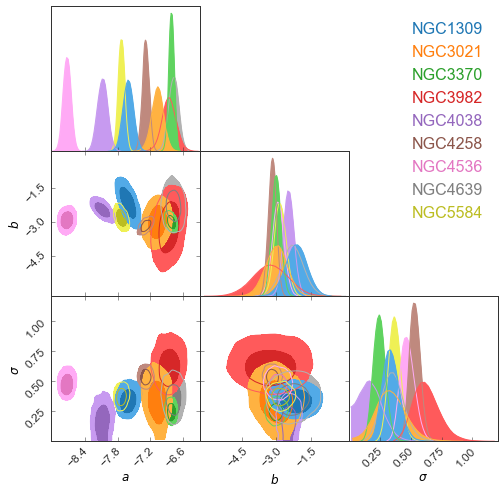

In [10]:
plotGTC(individual_samples, paramNames=param_labels, 
        chainLabels=['NGC'+str(g) for g in ngc_numbers],
        figureSize=8, customLabelFont={'size':12}, customTickFont={'size':12}, customLegendFont={'size':16});

Visually, would you say that it's likely that all the scaling parameters, or some subset, are universal?

yes

## 3. Strategy

Even more than in the [single-galaxy tutorial](cepheids_one_galaxy.ipynb), the total number of free parameters in the model is, technically, staggering. We will need to use some human intelligence to make this tractable.

### Analytic marginalization of the individual $M_{ij}$

> If you already completed the [single-galaxy tutorial](cepheids_one_galaxy.ipynb), this is a repeat. Feel free to answer the Markdown question below by saying so, and copy/paste your implementation of `log_likelihood_B` in the appropriate place.

If some parameters truly are nuisance parameters, in the sense that we don't care what their posteriors are, then we'll ultimately marginalize over them anyway. Rather than sampling the full-dimensional parameter space and then looking only at the marginal distributions we care about, we always have the option of sampling only parameters we care about, and, while evaluating _their_ posterior, doing integrals over the nuisance parameters in some other way. In other words, we should remember that obtaining samples of a parameter is only one method of integrating over it.

Whether it makes sense to go this route depends on the structure of the model (and how sophisticated you care to make your sampler). Somtimes, sampling the nuisance parameters just like the parameters of interest turns out to be the best option. Other times, direct integration is much more efficient. And, of course, "direct integration" could take many forms, depending on the integrand: an integral might be analytic, or it might be best accomplished by quadrature or by monte carlo integration. The dimensionality of the integration (in particular, whether it factors into one-dimensional, or at least low-dimensional, integrals) is something to consider.

In this case, it's relatively straightforward to analytically marginalize over the numerous $M_{ij}$ parameters. That would leave us with only 3 parameters left to sample per galaxy, plus the 6 $\mu$s and $\tau$s, for a total of $3N_\mathrm{gal}+6=33$ parameters. Brute force sampling of these remaining 33 parameters is not unthinkable, although in practice it may or may not be a headache.

So, for this model, write down the per-galaxy part of the likelihood (i.e., the part that would be within a product over galaxies), marginalized over the $M_{ij}$ parameters. Using results given in the [gaussians](gaussians.ipynb) tutorial, the corresponding integrals can be made analytic, greatly simplifying our lives. You should be left with a product of something simple (on paper), over cepheids $j$ in galaxy $i$.

In [ ]:
TBC() # answer in Markdown

### Importance weighting

Another option is to make use of the samples from individual-galaxy fits that we showed in Section 2. These are samples of the posterior, for each galaxy, when the priors on the scaling parameters are very wide and uniform, i.e. constant over the domain where the likelihood is significantly non-zero. They are, therefore, also samples from a PDF that is proportional to the likelihood function for the corresponding galaxy. To see why that might be helpful, consider the posterior for the hyperparameters of the new model, $\vec{\alpha} = (\mu_a,\tau_a,\mu_b,\tau_b,\mu_\sigma,\tau_\sigma)$, marginalized over all the pesky $a_i$, $b_i$ and $\sigma_i$ parameters:

$p(\vec{\alpha}|\mathrm{data}) \propto p(\vec{\alpha}) \prod_{i=1}^{N_\mathrm{gal}} \int da_i db_i d\sigma_i \, p(a_i,b_i,\sigma_i|\vec{\alpha}) \, p(\mathrm{data}|a_i,b_i,\sigma_i)$.

To restate what we said above, our individual fits (with uniform priors) give us samples from PDFs

$q(a_i,b_i,\sigma_i|\mathrm{data}) \propto p(\mathrm{data}|a_i,b_i,\sigma_i)$.

We can do this integral by simple monte carlo as

$p(\vec{\alpha}|\mathrm{data}) \propto p(\vec{\alpha}) \prod_{i=1}^{N_\mathrm{gal}} \frac{1}{n_i}\sum_{k=1}^{n_i} p(a_{ik},b_{ik},\sigma_{ik}|\vec{\alpha})$,

where the $n_i$ samples of $(a_{ik},b_{ik},\sigma_{ik}) \sim q(a_i,b_i,\sigma_i|\mathrm{data})$. Our samples from Section 2 happen to satisfy this. (Had we used a non-uniform prior before, we could do something similar, but would need to divide by that prior density in the sum above.) In effect, the product above and everything in it becomes an importance weight for the prior over $\alpha$ that directly allows us to approximate the posterior of those parameters.

This approach has the advantage that we only need to sample the 6 parameters in $\vec{\alpha}$ to constrain our hierarchical model, since a lot of work is already done. On the other hand, carrying out the sums for each galaxy can become its own numerical challenge.

### Other strategies

If we're really stuck in terms of computing power, we could consider a more compressed version of importance weighting, by approximating the posterior from each individual galaxy fit as a 3-dimensional Gaussian, or some other simple function. This approximation may or may not be a significant concession on our parts; here it's clearly a bit sketchy in the case of $\sigma$, which has a hard cut at $\sigma=0$ that at least one individual galaxy is consistent with. But, with this approximation, the integral in $p(\vec{\alpha}|\mathrm{data})$, above, could be done analytically, much as we simplified the single-galaxy likelihood.

Finally, not that this is an exhaustive list, we could consider whether conjugate Gibbs sampling is an option. Since the normal distribution has nice conjugacies, we could consider a scheme where we sample $\mu_a|\tau_a,\{a_i\}$, then $\tau_a|\mu_a,\{a_i\}$, then similarly for $\mu_b$, $\tau_b$, $\mu_\sigma$ and $\tau_\sigma$, and _then_ all the individual $a_i$, $b_i$, $\sigma_i$ and $M_{ij}$ parameters as we did with LRGS in the [single-galaxy tutorial](cepheids_one_galaxy.ipynb) (accounting for the normal "prior" on $a_i$ given by $\mu_a$ and $\tau_a$, etc.). Or we could conjugate-Gibbs sample the $\mu$'s and $\tau$'s, while using some other method entirely for the galaxy-specific parameters. (The Gaussian parent distribution is not conjugate for the $\sigma$ parameters, so at a minimum we would need to mix in some other sampling approach for those parameters.)

We won't walk through these last two strategies, but it's worth thinking more about what else might be possible.

## 4. Obtain the posterior

We're going to try this by brute-force sampling (though still using the analytic trick above to reduce the number of parameters to 33) and importance weighting. Let's get a few common bits of code written.

First, a common trick to reduce the posterior correlation between the intercept and slope parameters of a line is to reparametrize the model as $a+bx \rightarrow a' + b(x-x_0)$, where the "pivot" $x_0$ is roughly the mean of $x$ in the data. It isn't strictly necessary to do this, but smaller correlations usually mean faster convergence. Of course, it's important to remeber this redefinition when visualizing/interpreting the results! Below, we'll adopt a common pivot in `logP` for all the galaxies. This won't be the ideal pivot for any individual galaxy, but we'll still get most of the possible benefit of reducing the posterior correlation.

In [165]:
global_pivot = np.mean([data[i]['logP'].mean() for i in ngc_numbers])
for i in ngc_numbers:
    data[i]['pivot'] = global_pivot

Here's a function to evaluate the mean relation given by $a$ and $b$, with an extra argument for the pivot point:

In [166]:
def meanfunc(x, xpivot, a, b):
    '''
    x is log10(period/days)
    returns an absolute magnitude
    '''
    return a + b*(x - xpivot)

Next, implement the single-galaxy likelihood you derived above, using the analytic simplification. Don't include the $p(a_i,b_i,\sigma_i|\mu_a,\sigma_a,\ldots)$ piece here, only the likelihood for the observed magnitudes. If you did the [single-galaxy tutorial](cepheids_one_galaxy.ipynb) already, this will be identical to the function of the same name in that notebook.

In [167]:
def log_likelihood_B(gal, a, b, sigma):
    '''
    `gal` is an entry in the `data` dictionary; `a`, `b`, and `sigma` are scalars
    '''
    return np.sum( st.norm.logpdf(gal['M'], 
                           loc=meanfunc(gal['logP'], gal['pivot'], a, b), 
                           scale=sigma) )
# "posterior", taking a parameter array argument for compatibility with emcee
def logpost_vecarg_B(pvec):
    params = {name:pvec[i] for i,name in enumerate(param_names)}
    return log_posterior(data[g], log_likelihood_B, **params)


### 4a. Brute force

Let's first try to directly sample the 33 parameters left after we analytically simplify the likelihood, since attempting to sample these plus a free absolute magnitude for every cepheid in every galaxy is not to be thought of. We can make use of our array of `log_likelihood_B` function above (which, recall, only deals with a single galaxy).

The prototypes below assume the 33 parameters are ordered as: $(\mu_a,\tau_a,\mu_b,\tau_b,\mu_\sigma,\tau_\sigma,a_1,b_1,\sigma_1,a_2,b_2,\sigma_2,\ldots)$. Also, Let's... not include all the individual galaxy parameters in these lists of parameter names:

In [168]:
param_names_all  = ['mu_a', 'tau_a', 'mu_b', 'tau_b', 'mu_s', 'tau_s']
param_labels_all = [r'$\mu_a$', r'$\tau_a$', r'$\mu_b$', r'$\tau_b$', r'$\mu_\sigma$', r'$\tau_\sigma$']

Complete the log-likelihood function for this part. To avoid having extremely long argument lists, the `galparams` argument will be an array containing $(a_1,b_1,\sigma_1,a_2,b_2,\sigma_2,\ldots)$, from which we can extract $a_i$, $b_i$ and $\sigma_i$ for any galaxy. The line given to you accounts for the $\prod_{i=1}^{N_\mathrm{gal}} p(\mathrm{data}|a_i,b_i,\sigma_i)$ part, so what remains is $p(a_i,b_i,\sigma_i|\mu_a,\tau_a,\ldots)$ for each galaxy. Remember that the pdf for $\sigma_i$ is a _truncated_ normal, not a simple Gaussian.

In [211]:
def log_likelihood_all_A(mu_a, tau_a, mu_b, tau_b, mu_s, tau_s, galparams):
    a = np.array(galparams[0:len(galparams):3])
    b = np.array(galparams[1:len(galparams):3])
    s = np.array(galparams[2:len(galparams):3])
    lnp_magnitudes = np.sum([log_likelihood_B(data[g], aa, bb, ss) for g,aa,bb,ss in zip(ngc_numbers,a,b,s)])
    
    ap= np.sum(st.norm.logpdf(a,loc=mu_a,scale=tau_a))
    bp= np.sum(st.norm.logpdf(b,loc=mu_b,scale=tau_b))
    sp= np.sum(st.norm.logpdf(s,loc=mu_s,scale=tau_s))
    return lnp_magnitudes+ap+bp+sp

We also need a log-prior function, as always:

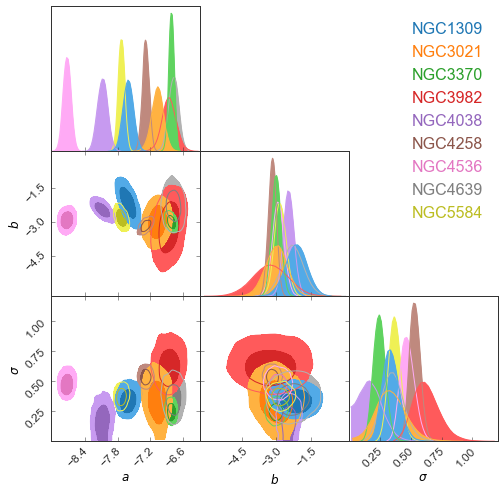

In [229]:
plotGTC(individual_samples, paramNames=param_labels, 
        chainLabels=['NGC'+str(g) for g in ngc_numbers],
        figureSize=8, customLabelFont={'size':12}, customTickFont={'size':12}, customLegendFont={'size':16});

In [231]:
def log_prior_all(mu_a, tau_a, mu_b, tau_b, mu_s, tau_s, **kwargs):
    if -10.0 < mu_a < -4.0 and -6.0 < mu_b < -0.5 and 0 <mu_s <1.5 and 0<tau_a<2 and 0<tau_b<2 and 0<tau_s<1:
        return 0.0
    return -np.inf

You can have the log-posterior function. We've written it to take the likelihood function as an argument, so it can be re-used in the next section.

In [232]:
def log_posterior_all(loglike, **params):
    lnp = log_prior_all(**params)
    if lnp != -np.inf:
        lnp += loglike(**params)
    return lnp

# array argument for emcee compatibility
def logpost_vecarg_all_A(pvec):
    params = {name:pvec[i] for i,name in enumerate(param_names_all)}
    params['galparams'] = pvec[len(param_names_all):]
    return log_posterior_all(log_likelihood_all_A, **params)

In [233]:
param_names_all

['mu_a', 'tau_a', 'mu_b', 'tau_b', 'mu_s', 'tau_s']

Based on the triangle plot in the first section, guess rough starting values for $(\mu_a,\tau_a,\mu_b,\tau_b,\mu_\sigma,\tau_\sigma)$.

In [234]:
guess_all = {'mu_a':-7.0, 'tau_a':0.15, 'mu_b':-3.0, 'tau_b':0.5,
             'mu_s':0.5, 'tau_s':0.1}

We'll add guesses for each galaxy's $a$, $b$ and $\sigma$ based on the mean of its individual-fit posterior, and store everything in one list:

In [235]:
guess_all_A = [guess_all[k] for k in param_names_all] + \
              list(np.concatenate([samples.mean(axis=0) for samples in individual_samples]))

Quick check that the functions above produce numbers:

In [236]:
logpost_vecarg_all_A(guess_all_A)

-5199662.969994177

The cell below will set up and run `emcee` using the functions defined above. We've made some generic choices, such as using twice as many "walkers" as free parameters, and starting them distributed according to a Gaussian around `guess_all_A` with a width of 1%.

#### IMPORTANT

You do **not** need to run this version long enough to get what we would normally consider acceptable results, in terms of convergence and number of independent samples. Just convince yourself that it's functioning, and get a sense of how it performs (i.e., it it close to convergence already? how correlated are the samples?). The 300 steps below should be fine, unless your starting guess was particularly strange. **Please do not turn in a notebook where the sampling cell below takes longer than $\sim30$ seconds to evaluate.**

In [237]:
%%time

nsteps = 300

npars = len(guess_all_A)
nwalkers = 2*npars
sampler = emcee.EnsembleSampler(nwalkers, npars, logpost_vecarg_all_A)
start = np.array([np.array(guess_all_A)*(1.0 + 0.01*np.random.randn(npars)) for j in range(nwalkers)])
sampler.run_mcmc(start, nsteps)
print('Yay!')

Yay!
CPU times: user 48.5 s, sys: 730 ms, total: 49.2 s
Wall time: 53.5 s


Look at the traces (we'll only include one of the galaxy's scaling parameters).

In [238]:
param_labels1 = ['$a_1$', '$b_1$', '$\\sigma_1$']

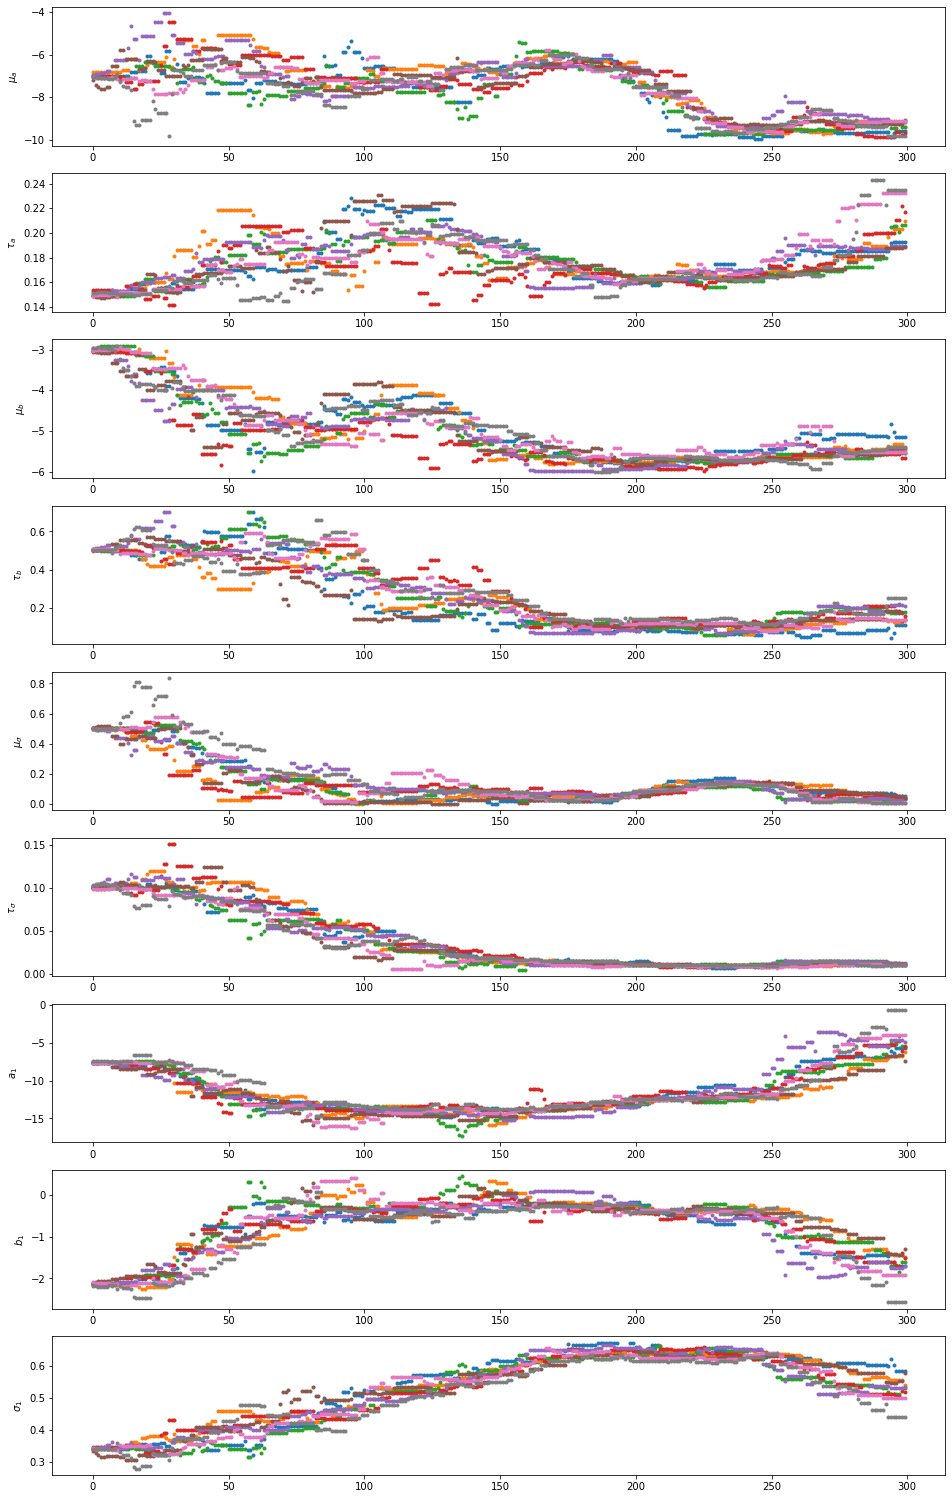

In [239]:
npars = len(guess_all)+3
plt.rcParams['figure.figsize'] = (16.0, 3.0*npars)
fig, ax = plt.subplots(npars, 1);
cr.plot_traces(sampler.chain[:min(8,nwalkers),:,:npars], ax, labels=param_labels_all+param_labels1);
npars = len(guess_all_A)

Chances are this is not very impressive. But we carry on, to have it as a point of comparison. The cell below will print out the usual quantitiative diagnostics for the subset of parameters shown above.

In [243]:
burn = 150
maxlag = 100

tmp_samples = [sampler.chain[i,burn:,:9] for i in range(nwalkers)]
print('R =', cr.GelmanRubinR(tmp_samples))
print('neff =', cr.effective_samples(tmp_samples, maxlag=maxlag))
print('NB: Since walkers are not independent, these will be optimistic!')
print("Plus, there's a good chance that the results in this section are garbage...")

R = [1.02015831 1.05704828 1.10028319 1.08262755 1.04949947 1.10317239
 1.01598582 1.02357363 1.04842122]
neff = [165.72989163 211.9613099  214.45011067 218.52638505 269.1471113
 205.22201379 149.23649792 161.93356261 198.12886898]
NB: Since walkers are not independent, these will be optimistic!
Plus, there's a good chance that the results in this section are garbage...


As before, we'll be comparing the posteriors from the methods we attempt:

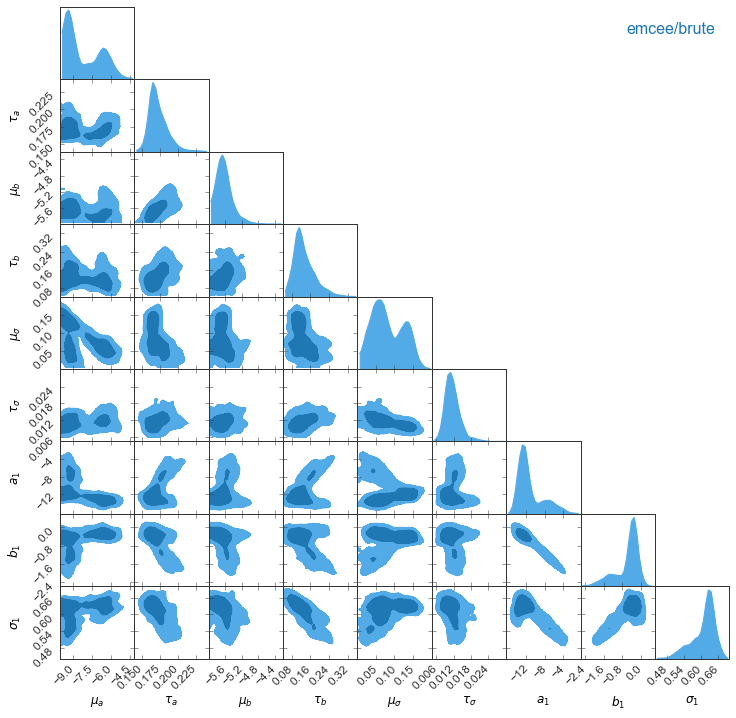

In [244]:
samples_all_A = sampler.chain[:,burn:,:].reshape(nwalkers*(nsteps-burn), npars)
plotGTC([samples_all_A[:,:9]], paramNames=param_labels_all+param_labels1, chainLabels=['emcee/brute'],
        figureSize=12, customLabelFont={'size':12}, customTickFont={'size':12}, customLegendFont={'size':16});

To be more thorough, we would also want to see how well the new hierarchical part of the model fits, meaning whether the posteriors of $a_i$, $b_i$ and $\sigma_i$ are collectively consistent with being drawn from their respective fitted Gaussians. Things might look slightly different than the plots we made at the start of this notebook, since those fits used uniform priors rather than the hierarchical model. With only 9 galaxies, it seems unlikely that we could really rule out a Gaussian distribution, and it's tangential to the point of this tutorial. So this can be an exercise for the reader, if you want.

Comment on what you've seen in this section vs the previous one. Do you think the brute-force approach has converged (and why/not)?

Yes

### 4b. Sampling with numerical marginalization

Let's see how we do trying to marginalize out the per-galaxy parameters by simple monte carlo, as described above:

$p(\mathrm{data}|\vec{\alpha}) = \prod_{i=1}^{N_\mathrm{gal}} \frac{1}{n_i}\sum_{k=1}^{n_i} p(a_{ik},b_{ik},\sigma_{ik}|\vec{\alpha})$.

Note that, because we are taking a sum of probabilities above, we do actually need to work with **probabilities**, as opposed to **log-probabilities**. You might reasonably worry about numerical stability here, but in this case a naive implementation seems to be ok. (In general, what we would need to check is whether the summands contributing most of the sum are easily floating-point representable, i.e. not so tiny that they underflow. We could always renormalize the summands to avoid this, since we will just end up taking the log afterwards.)

Implement the log-likelihood for this approach below. I suggest just addressing `individual_samples` from global scope, which is not great coding style, but simpler than the alternative.

In [276]:
shapes=np.array(individual_samples).shape
shapes

(9, 500, 3)

In [277]:
def log_likelihood_all_B(mu_a, tau_a, mu_b, tau_b, mu_s, tau_s):
    Ngal,samples,absig=shapes
    prob=1
    for i in range(Ngal):
        dat_a=[individual_samples[i][j][0] for j in range(samples)]
        dat_b=[individual_samples[i][j][1] for j in range(samples)]
        dat_s=[individual_samples[i][j][2] for j in range(samples)]
        prob_a=st.norm.pdf(dat_a,loc=mu_a,scale=tau_a)
        prob_b=st.norm.pdf(dat_b,loc=mu_b,scale=tau_b)
        prob_s=st.norm.pdf(dat_s,loc=mu_s,scale=tau_s)
        new_prob=np.average([prob_a[i]*prob_b[i]*prob_s[i] for i in range(samples)])
        prob*=new_prob
    return np.log(prob)

This is yours for free:

In [278]:
def logpost_vecarg_all_B(pvec):
    params = {name:pvec[i] for i,name in enumerate(param_names_all)}
    return log_posterior_all(log_likelihood_all_B, **params)

The usual check:

In [279]:
guess_all_B = guess_all_A[:len(param_names_all)]
logpost_vecarg_all_B(guess_all_B)

-91.03906530178584

Let's get an idea of how computationally expensive all these sums are by running a very short chain.

In [262]:
nsteps = 10

npars = len(guess_all_B)
nwalkers = 2*npars
sampler = emcee.EnsembleSampler(nwalkers, npars, logpost_vecarg_all_B)
start = np.array([np.array(guess_all_B)*(1.0 + 0.01*np.random.randn(npars)) for j in range(nwalkers)])
%time sampler.run_mcmc(start, nsteps)
print('Yay?')

CPU times: user 2min, sys: 2.84 s, total: 2min 3s
Wall time: 2min 37s
Yay?


For me this comes out to about 4 seconds for 10 steps - slower than we'd ideally like, at least without more serious computing resources than my laptop. (If you run longer, though, you should see performance better than in part A.)

However, its worth asking if we can get away with using fewer samples. In principle, we are well justified in doing this, since the effective number of independent samples estimated for some of the individual fits are only $\sim500$.

Assuming that you followed my terrible suggestion to access `individual_samples` from global scope in `log_likelihood_all_B()`, let's make a copy of the former for safe keeping, and then do the thinning.

In [263]:
individual_samples_backup = [samples.copy() for samples in individual_samples] # don't run this more than once!

In [264]:
thinto = 500
individual_samples = [samples[::int(samples.shape[0]/thinto)] for samples in individual_samples_backup]

In [272]:
np.array(individual_samples).shape

(9, 500, 3)

With only 500 samples left in the sum for each galaxy, it should be possible to get results that appear basically converged, if not well sampled, in a couple thousand steps. This is the rare occasion when we'll ask you to run a cell that takes more than 30 seconds or so (a little over a minute on my laptop). You may want to run a shorter test chain to verify that everything is working, before committing to 2000 steps, however.

In [280]:
%%time

nsteps = 2000

npars = len(guess_all_B)
nwalkers = 2*npars
sampler = emcee.EnsembleSampler(nwalkers, npars, logpost_vecarg_all_B)
start = np.array([np.array(guess_all_B)*(1.0 + 0.01*np.random.randn(npars)) for j in range(nwalkers)])
sampler.run_mcmc(start, nsteps);
print('Yay!')

<ipython-input-277-64e3376e11a1>:13: RuntimeWarning: divide by zero encountered in log
  return np.log(prob)


Yay!
CPU times: user 6min 49s, sys: 5.76 s, total: 6min 54s
Wall time: 7min 41s


Let's see how it did:

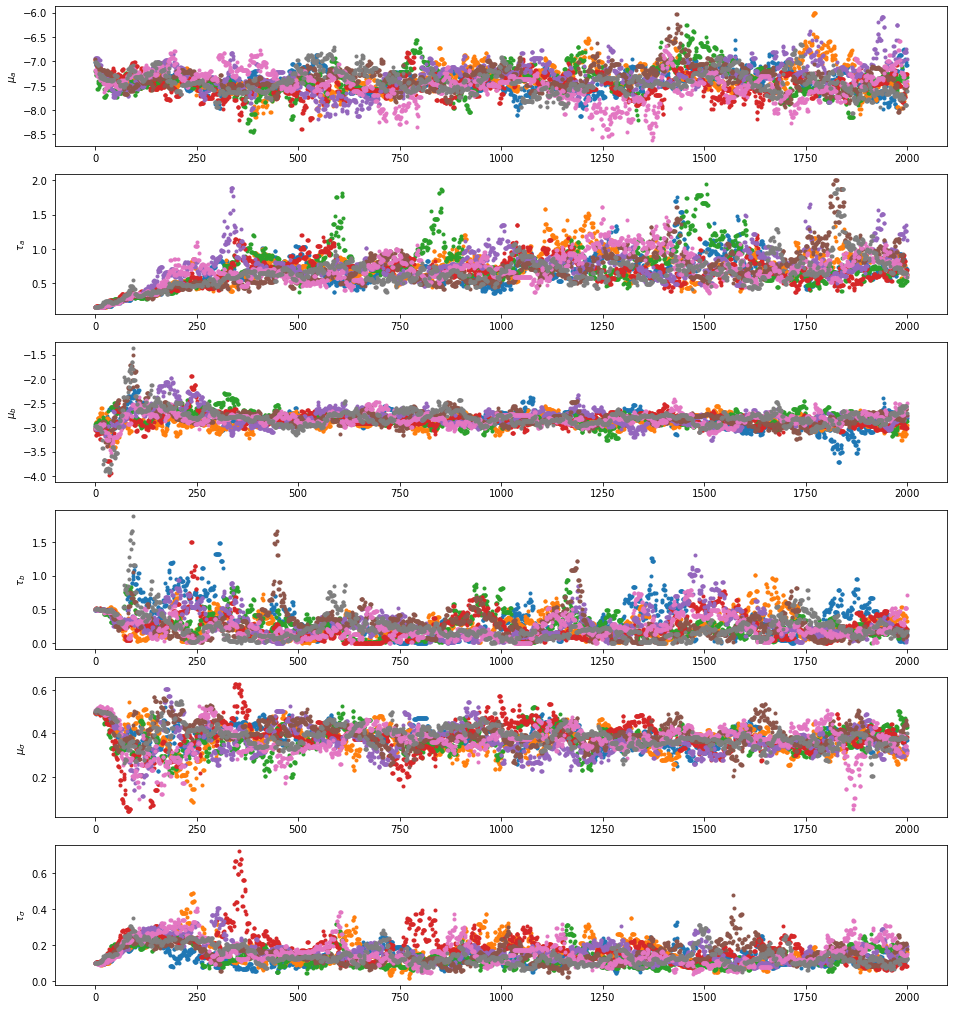

In [281]:
plt.rcParams['figure.figsize'] = (16.0, 3.0*npars)
fig, ax = plt.subplots(npars, 1);
cr.plot_traces(sampler.chain[:min(8,nwalkers),:,:npars], ax, labels=param_labels_all);

The sampler is probably struggling to move around efficiently, but you could imagine running patiently for a while and ending up with something useful. Let's call this approach viable, but not ideal. Still, make sure you have reasonable convergence before continuing.

In [282]:
burn = 200
maxlag = 300

tmp_samples = [sampler.chain[i,burn:,:] for i in range(nwalkers)]
print('R =', cr.GelmanRubinR(tmp_samples))
print('neff =', cr.effective_samples(tmp_samples, maxlag=maxlag))
print('NB: Since walkers are not independent, these will be optimistic!')

R = [1.03234226 1.03135787 1.02032003 1.0207837  1.02598887 1.03319688]
neff = [199.26076523 170.86829042 182.23444841 231.00431761 188.08293697
 142.99219325]
NB: Since walkers are not independent, these will be optimistic!


And now the burning question: how does the posterior compare with the brute force version?

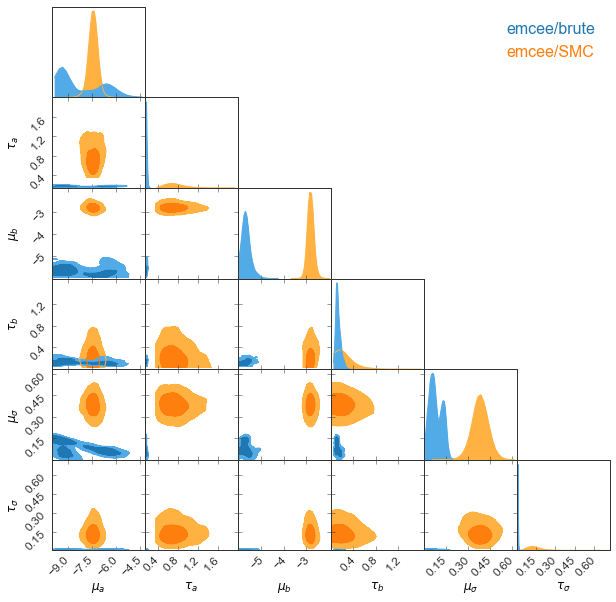

In [283]:
samples_all_B = sampler.chain[:,burn:,:].reshape(nwalkers*(nsteps-burn), npars)
plotGTC([samples_all_A[:,:len(param_names_all)], samples_all_B], paramNames=param_labels_all, chainLabels=['emcee/brute', 'emcee/SMC'],
        figureSize=10, customLabelFont={'size':12}, customTickFont={'size':12}, customLegendFont={'size':16});

**Checkpoint:** Your posterior is compared with our solution by the cell below. Keep in mind they may have very different numbers of (effectively independent) samples - we let ours run for several minutes.

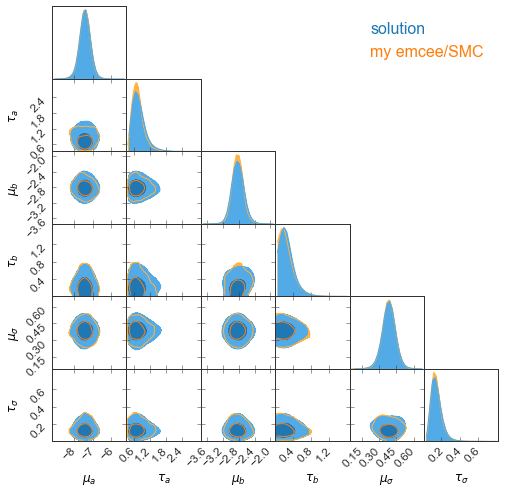

In [284]:
sol = np.loadtxt('ceph2.dat.gz')
plotGTC([sol, samples_all_B], paramNames=param_labels_all, chainLabels=['solution', 'my emcee/SMC'],
        figureSize=8, customLabelFont={'size':12}, customTickFont={'size':12}, customLegendFont={'size':16});

Comment on things like the efficiency, accuracy, and/or utility of the approaches in these two sections.

An extra step in this case would be needed to ensure that our results are robust - we would want to make sure that we are using enough samples of the individual fit posteriors that our final constraints are converged in that sense. Realistically, this would probably mean running each of those fits for significantly longer, and then using more samples in this final step, with all the computing overhead that entails.

### Aside 

There is a fun pathology that can come up with this technique, though thankfully it doesn't appear to have done so here. In brief, when the intrinsic scatter for some quantity is consistent with zero, the sampler may pick up on the effective scatter which is present because we have only discrete samples as we integrate. In other words, there's a lower limit to how well values of $a$ (for example) for the different galaxies can agree in practice, but this lower limit is an artifact of the discrete sampling. This scatter can in principle provide a very strong, unwanted signal, resulting in a sharp peak in the posterior samples at small values of $\tau_a$. Yet, this spike would be spurious, as it wouldn't exist if we were doing the integrations in some another way that allowed multiple galaxies to have exactly the same value of $a$. As we can see here, this issue doesn't always arise, but it's something to watch out for.

## Finishing up

On the basis of your results, for which of the population parameters, if any, is the intrinsic scatter consistent with zero, and why/not?

You might be wondering about the fact that we've arrived at "Finishing up" without having checked, even visually, that the model describes the data well. In the case of the hierarchical layer we added in this notebook, we would want to ask whether the a posteriori distributions of $a_i$, $b_i$ and $\sigma_i$ are indeed reasonably consistent with the Gaussian shape we assumed. _This one time_, we're going to skip the exercise, mostly because with only 9 galaxies it seems unlikely that we could say very much, and partly because this was a situation where we had to assume _something_ - so the more interesting question is whether some other distribution performs better (though we would still need some visualization to motivate a particular alternative).